# Predicting who goes to the Cooperstown using XGBoost

**author:** `bpdaum`

**date:** `2025-12-29`

---

## 1. Laying out the problem

The hall of fame is the pinnacle of achievement for many baseball players - to be forever memorialized in the hallowed halls of Cooperstown. It's well known in baseball circles, however, that the criteria for getting into the Hall are remarkably subjective, and also subject to temporal drift (what mattered to Halls voters in 1970 isn't necessarily what voters are about in 2025). This makes classifying HoF potential a pretty fun and interesting problem to chase, especially when trying to build a model that might be more durable across eras.

To do this, I've pulled some some CSV's from the Lahamn baseball database to load batting data (we won't focus on pitchers for now) and try to predict HoF likelihood. We'll also build two simple baselines to try to frame our problem effectively (i.e. can we outperform random selection and simple heuristically-driven systems)?


## 2. Loading the data

First, install libraries / ensure our needed libraries are installed in our runtime.

In [12]:
# Install dependencies (if needed)
!pip install pandas numpy xgboost scikit-learn matplotlib seaborn shap

Now we'll instantiate our libraries and load our data.

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve,
                             f1_score, recall_score, precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('fivethirtyeight')
# Initialize JS for SHAP plots
shap.initjs()

We're loading a *lot* of data for this project from the Fangraphs API, so we'll get blocked if we try to load too much data. We'll do a simple for loop and use the `pd.concat` function to get our data loaded into a dataframe.

In [15]:
# Define paths (Adjust if your notebook is running from a different directory)
DATA_DIR = 'baseball/'

try:
    df_batting = pd.read_csv(os.path.join(DATA_DIR, 'Batting.csv'))
    df_hof = pd.read_csv(os.path.join(DATA_DIR, 'HallOfFame.csv'))
    df_people = pd.read_csv(os.path.join(DATA_DIR, 'People.csv'))

    print("Data Loaded Successfully!")
    print(f"Batting: {df_batting.shape}")
    print(f"HOF: {df_hof.shape}")
    print(f"People: {df_people.shape}")

except FileNotFoundError:
    print("Error: CSV files not found. Please check the DATA_DIR path.")

Data Loaded Successfully!
Batting: (126907, 24)
HOF: (6418, 9)
People: (24023, 25)


## 3. Data cleaning and feature engineering

There's a lot of ways we can do this, but I'll do some light feature engineering to help us with our prediction problem. We also need to do some filtering (active players obviously can't be in the hall yet and would bias our model, and we need to remove people who haven't had significant careers) and I'll add some slightly more advanced stats (OPS, K and BB rate) that might help with prediction power.

In [69]:
# 1. Aggregate Batting Stats by PlayerID
# Added HBP (Hit by Pitch) and SF (Sacrifice Fly) for accurate OBP calculation
cols_to_sum = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'HBP', 'SF']

# Ensure columns are numeric and fill nulls with 0
# More advanced imputation could be a good idea in some cases, but for
# this exercise, this should be fine
for col in cols_to_sum:
    if col in df_batting.columns:
        df_batting[col] = pd.to_numeric(df_batting[col], errors='coerce').fillna(0)

# We need yearID to calculate career span and decade
career_stats = df_batting.groupby('playerID').agg(
    {**{col: 'sum' for col in cols_to_sum},
     'yearID': ['min', 'max']}  # Get First and Last Year
).reset_index()

# Fix col names
new_cols = []
for col in career_stats.columns.values:
    if col[1] == 'sum':
        new_cols.append(col[0]) # Keep original name for sums (e.g. 'AB' not 'AB_sum')
    elif col[1]:
        new_cols.append(f"{col[0]}_{col[1]}") # Keep suffix for others (e.g. 'yearID_min')
    else:
        new_cols.append(col[0]) # Keep index name 'playerID'

career_stats.columns = new_cols

# Rename year columns for clarity
career_stats.rename(columns={'yearID_min': 'FirstYear', 'yearID_max': 'LastYear'}, inplace=True)



## Feature Engineering
# Simple batting average
career_stats['AVG'] = np.where(career_stats['AB'] > 0, career_stats['H'] / career_stats['AB'], 0)

# Total years played
career_stats['YearsPlayed'] = career_stats['LastYear'] - career_stats['FirstYear'] + 1

# Calculate 'Primary Decade' (midpoint of career rounded to nearest 10)
career_stats['Decade'] = (((career_stats['FirstYear'] + career_stats['LastYear']) / 2) // 10 * 10).astype(int)

# Plate Appearances (PA)
career_stats['PA'] = career_stats['AB'] + career_stats['BB'] + career_stats['HBP'] + career_stats['SF']

# On-Base Percentage (OBP)
career_stats['OBP'] = np.where(career_stats['PA'] > 0,
                               (career_stats['H'] + career_stats['BB'] + career_stats['HBP']) / career_stats['PA'], 0)
# Slugging Percentage (SLG)
# TB = H + 2B + 2*3B + 3*HR
total_bases = career_stats['H'] + career_stats['2B'] + (2 * career_stats['3B']) + (3 * career_stats['HR'])
career_stats['SLG'] = np.where(career_stats['AB'] > 0, total_bases / career_stats['AB'], 0)

# On-Base Plus Slugging (OPS)
career_stats['OPS'] = career_stats['OBP'] + career_stats['SLG']

# Isolated Power (ISO)
career_stats['ISO'] = career_stats['SLG'] - career_stats['AVG']

# Walk Rate and Strikeout Rate
career_stats['BB_Rate'] = np.where(career_stats['PA'] > 0, career_stats['BB'] / career_stats['PA'], 0)
career_stats['K_Rate']  = np.where(career_stats['PA'] > 0, career_stats['SO'] / career_stats['PA'], 0)

## Cleaning to get data re-merged
# 4. Merge with People to get Names
career_stats = career_stats.merge(df_people[['playerID', 'nameFirst', 'nameLast']], on='playerID', how='left')
career_stats['Name'] = career_stats['nameFirst'] + ' ' + career_stats['nameLast']

# Filter for significant careers (> 2000 ABs)
career_stats = career_stats[career_stats['AB'] > 2000]

print(f"All Players (Significant Careers): {len(career_stats)}")

# Get list of inducted IDs (inducted = 'Y')
hof_inductees = df_hof[df_hof['inducted'] == 'Y']['playerID'].unique()

# Create Target Column
career_stats['is_hof'] = career_stats['playerID'].isin(hof_inductees).astype(int)

# --- FILTERING STEP ---
ELIGIBILITY_CUTOFF = 2019

df_eligible = career_stats[career_stats['LastYear'] < ELIGIBILITY_CUTOFF].copy()
df_future = career_stats[career_stats['LastYear'] >= ELIGIBILITY_CUTOFF].copy()

print(f"Training Set (retired before {ELIGIBILITY_CUTOFF}): {len(df_eligible)} players")
print(f"Future Prediction Set (active/recent): {len(df_future)} players")
career_stats[['Name', 'Decade', 'YearsPlayed', 'OPS']].head()

All Players (Significant Careers): 2677
Training Set (retired before 2019): 2365 players
Future Prediction Set (active/recent): 312 players


,Name,Decade,YearsPlayed,OPS
1,Hank Aaron,1960,23,0.928462
7,Ed Abbaticchio,1900,14,0.650245
18,Kurt Abbott,1990,9,0.727778
39,Bobby Abreu,2000,19,0.869741
43,Jose Abreu,2010,11,0.833013


## 4 - EDA and visualization
Always a good idea to inspect your data! I'll do a few plots here to explore how the features relate to HoF status and also to each other. We'll start with a correlation matrix.

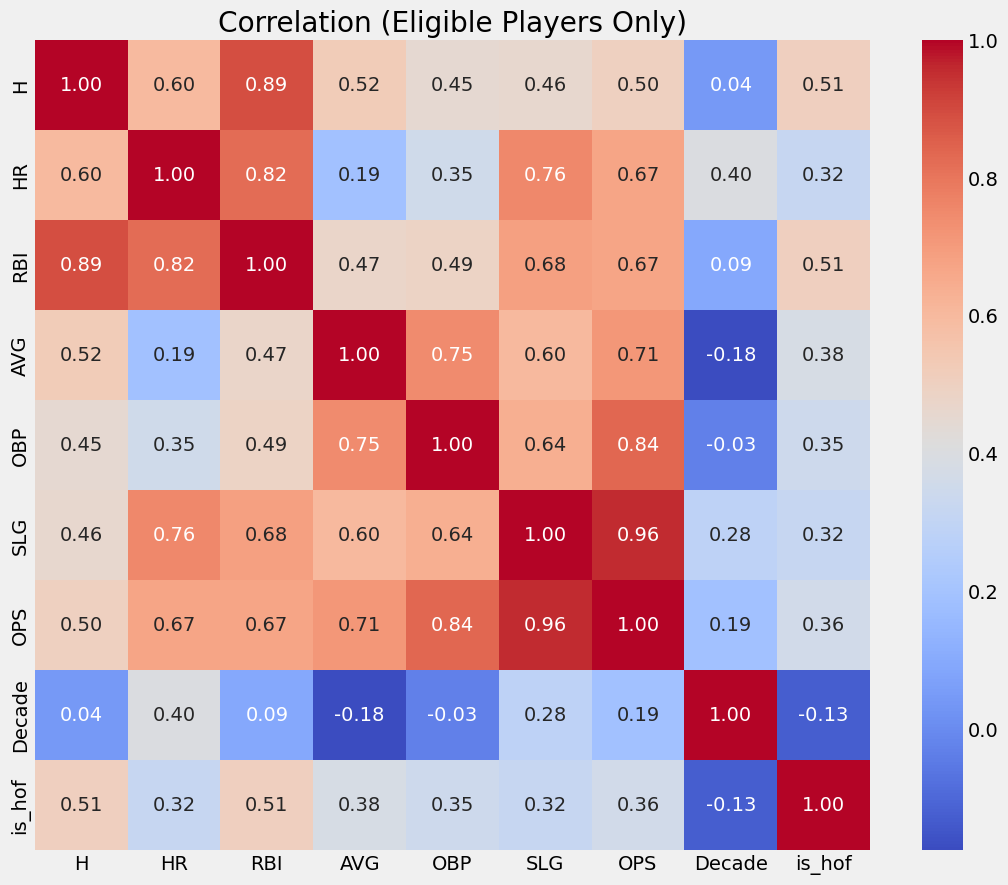

In [73]:
# Pearson Correlation Heatmap
plt.figure(figsize=(12, 10))
features_to_plot = ['H', 'HR', 'RBI', 'AVG', 'OBP', 'SLG', 'OPS', 'Decade', 'is_hof']
sns.heatmap(df_eligible[features_to_plot].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation (Eligible Players Only)')
plt.show()

Hits and RBIs have the strongest correlation to hall of fame status (unsurprisingly), and the decade played has a negative correlation (indicating that hall of frame induction rate seems to decrease as we get to more modern eras).

Let's also look at how career hits and OPS correlate, and see if there's any apparent relationship or cutoffs where they might indicate getting into Cooperstown. 3k hits is a legendary milestone, so we'll plot that; we'll also add a line for 0.900 OPS as that's a very strong career OPS level.

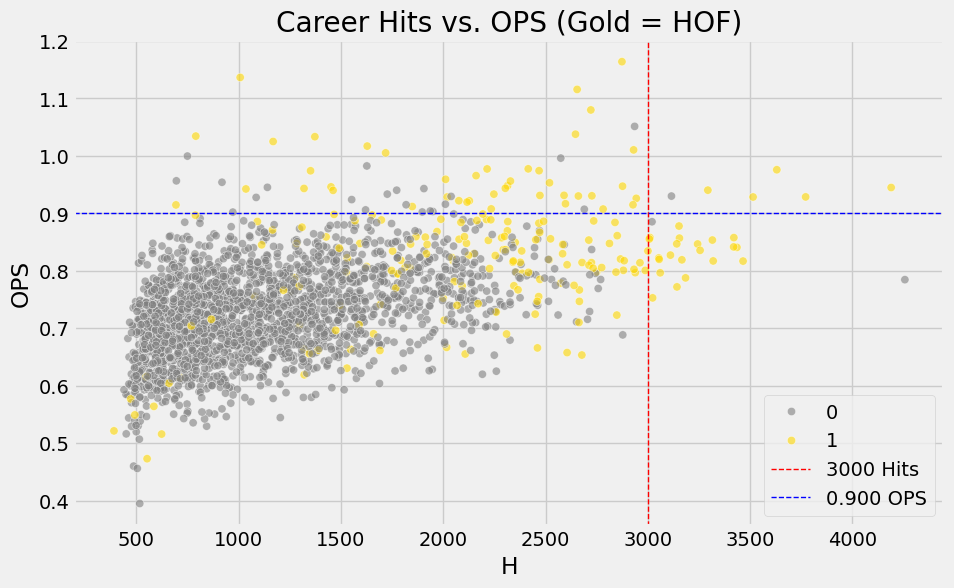

In [72]:
# Scatter Plot: OPS vs. Hits
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_eligible, x='H', y='OPS', hue='is_hof', alpha=0.6, palette={0: 'gray', 1: 'gold'})
plt.title('Career Hits vs. OPS (Gold = HOF)')
plt.axvline(x=3000, color='red', linestyle='--', linewidth=1, label='3000 Hits')
plt.axhline(y=0.900, color='blue', linestyle='--', linewidth=1, label='0.900 OPS')
plt.legend()
plt.show()

Lastly, we'll do a few boxplots to look at OPS, RBIs, and years played split by HoF status.

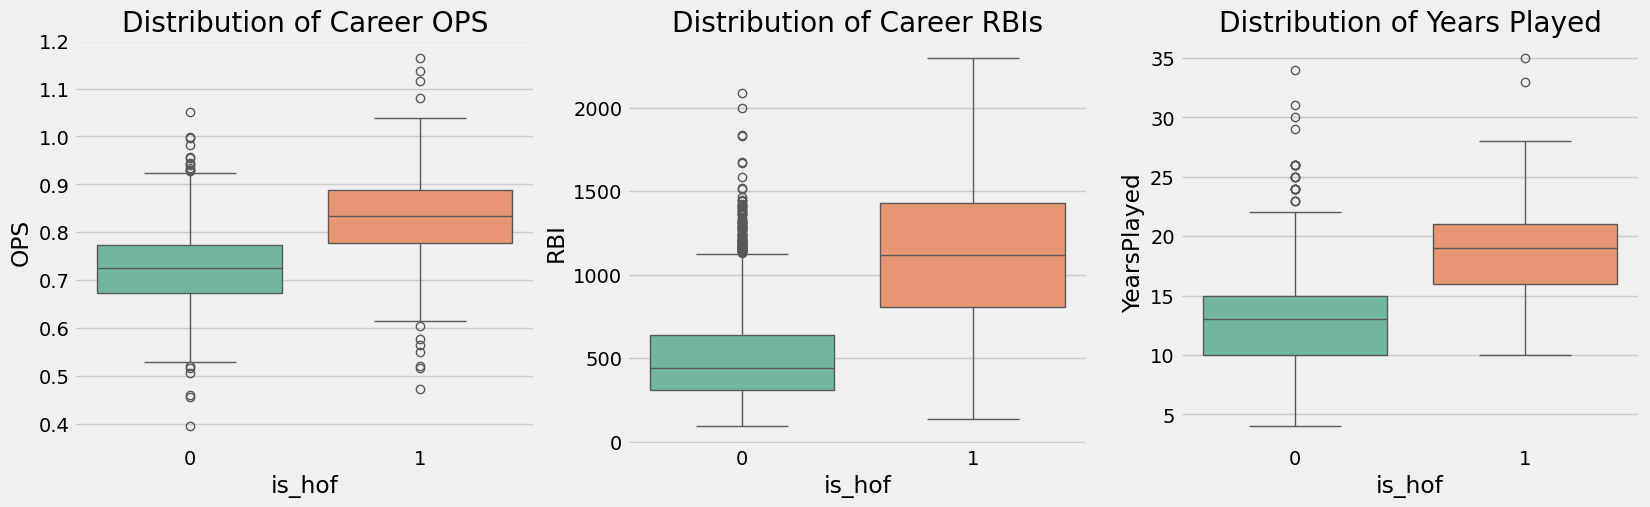

In [79]:
# 3. Box Plots: Statistical Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='is_hof',
            y='OPS',
            data=df_eligible,
            ax=axes[0],
            hue='is_hof',
            legend=False,
            palette='Set2')
axes[0].set_title('Distribution of Career OPS')

sns.boxplot(x='is_hof',
            y='RBI',
            data=df_eligible,
            ax=axes[1],
            hue='is_hof',
            legend=False,
            palette='Set2')
axes[1].set_title('Distribution of Career RBIs')

sns.boxplot(x='is_hof',
            y='YearsPlayed',
            data=df_eligible,
            ax=axes[2],
            hue='is_hof',
            legend=False,
            palette='Set2')
axes[2].set_title('Distribution of Years Played')

plt.show()

## 5 - Modeling

Now let's build our model. GBT's are very powerful for classification problems on binary data, and also have the advantage of being more interpretable than other methods (like NNs), but are a bit less interpretable than things like logistic regression. We'll build a binary classifier with `XGBoost`, evaluate the model's performance, inspect the model for insights using SHAP, and then use the model to try and predict who will go into the hall from our held out data.

In [80]:
features = [
    'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO',
    'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BB_Rate', 'K_Rate',
    'YearsPlayed', 'Decade'
]
X = df_eligible[features]
y = df_eligible['is_hof']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Train XGBoost
# We could do some hyperparameter tuning here, but we'll use mostly defaults
# for now.
model = xgb.XGBClassifier(eval_metric='logloss',
                          n_estimators=200,
                          random_state=42)
model.fit(X_train, y_train)

print("Model Trained Successfully on Eligible Players.")

Model Trained Successfully on Eligible Players.


Accuracy:  0.9598
Precision: 0.7949
Recall:    0.7381 (Correctly identified HOFers)
F1 Score:  0.7654
ROC-AUC:   0.9634


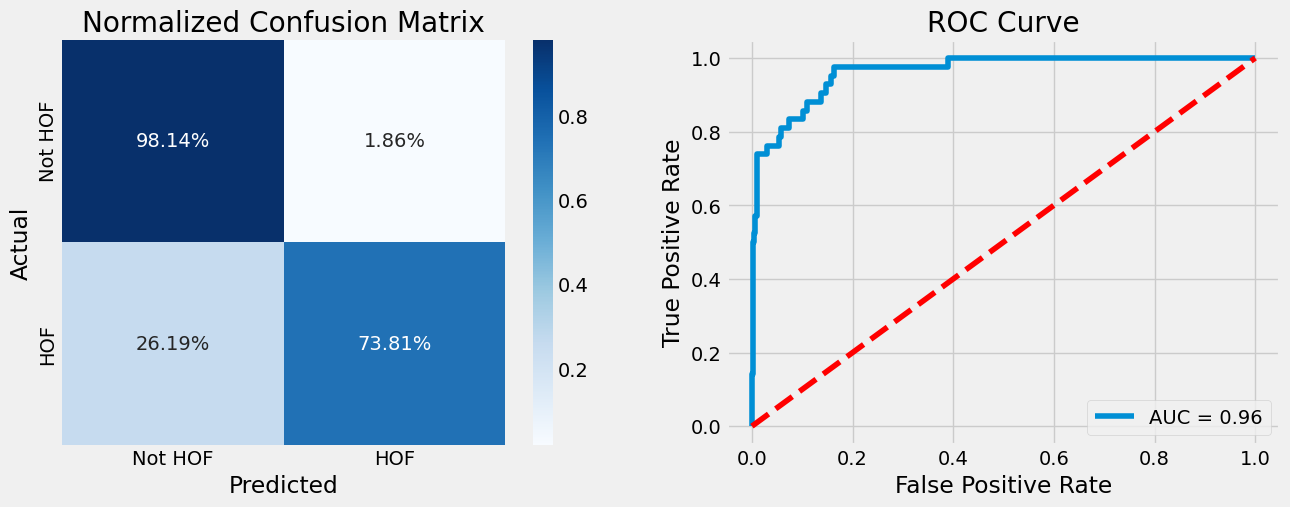

In [81]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f} (Correctly identified HOFers)")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Confusion Matrix (Normalized)
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Not HOF', 'HOF'])
axes[0].set_yticklabels(['Not HOF', 'HOF'])

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')

plt.show()

Given the imbalance in the target data, accuracy isn't a very helpful diagnostic metric for performance (but stakeholders usually want to see it anyway, so included). ROC-AUC of 0.96 indicates a very strong model, with ~80% precision and ~74% recall and an F1 score of ~0.77. While not perfect, this model's performance is quite good at discriminating between those that are not hall of famers and those that are.

## 6 - Exploring feature attributions with SHAP

We'll use SHAP (Shapley Values) to explore our features and how they contribute to predictive power to draw more insights from our model.

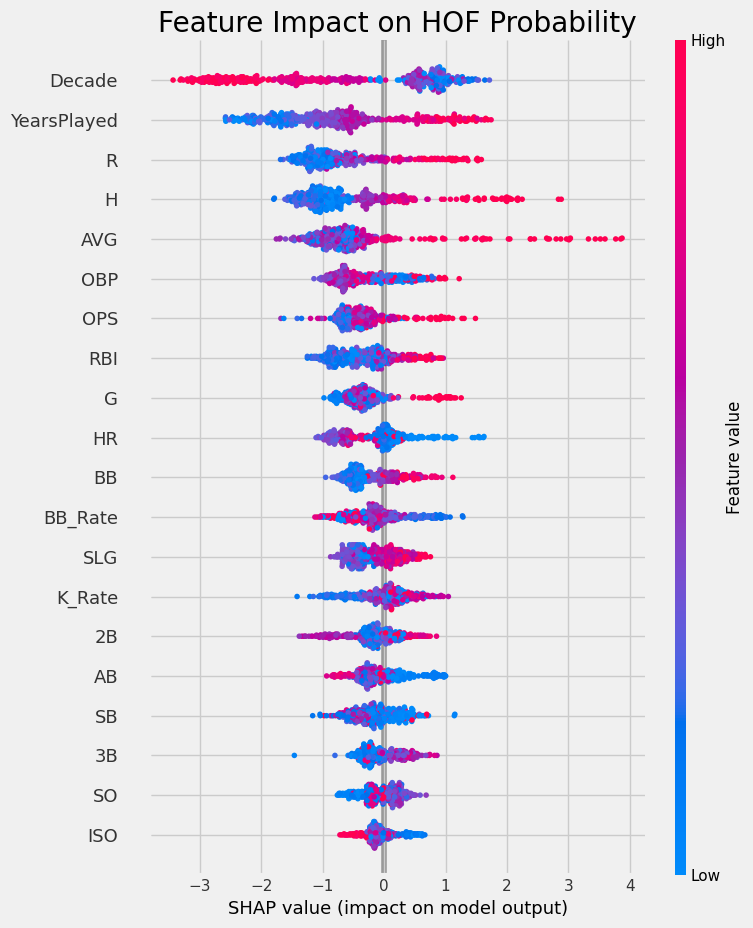

In [67]:
# Create the explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.title("Feature Impact on HOF Probability")
shap.summary_plot(shap_values, X_test, plot_type="dot")

Some insights I take away from this plot:

*   The decade you played in has a very strong influence on your likelihood to get into the hall, with earlier players (~1970s) having a much higher chance to get into the hall than more modern players. This is likely attributable at least in part to older players having more chances to be inducted, plus possibly some effects of it being easier to get in the hall than it is in the modern era.
*   Players with longer careers tend to be more likely to make it into the hall, which follows intuitively. It's also probably correlated that good players play longer, which could explain its high weight here.
*   Good hitters (unsurprisingly) are more likely to be hall of famers. The most predictive batting stats are runs, hits, average, and OBP. I'm somewhat surprised that RBI doesn't have more contribution as it was a core stat that I would expect many voters to have put more weight on in earlier eras.

Lots more rich insights to be drawn but we'll stop there for now!

## 7 - Who's gonna be next in the hall?

Now for the fun part, let's predict from our held out data who's likely to be inducted in the future!



In [85]:
X_future = df_future[features]

# Predict Probabilities
future_probs = model.predict_proba(X_future)[:, 1]

df_future['HOF_Probability'] = future_probs

# Top 20 candidates
top_candidates = df_future.sort_values(by='HOF_Probability', ascending=False).head(20)

top_candidates[['Name', 'HOF_Probability', 'H', 'HR', 'OPS', 'YearsPlayed', 'Decade']]

,Name,HOF_Probability,H,HR,OPS,YearsPlayed,Decade
3019,Miguel Cabrera,0.699851,3174,511,0.900503,21,2010
20827,Ichiro Suzuki,0.698466,3089,117,0.756883,19,2010
17242,Albert Pujols,0.188166,3384,703,0.918056,22,2010
3197,Robinson Cano,0.125079,2639,335,0.838613,18,2010
7079,Freddie Freeman,0.009114,2267,343,0.898874,15,2010
4686,Nelson Cruz,0.005560,2053,464,0.855978,19,2010
346,Jose Altuve,0.003883,2232,229,0.830620,14,2010
7877,Paul Goldschmidt,0.002119,2056,362,0.891826,14,2010
22102,Joey Votto,0.002069,2135,356,0.920476,17,2010
13483,Jeff Mathis,0.001824,526,53,0.551141,17,2010


Anecdotally (and as a baseball fan), Miggy, Ichiro, and Pujols are clear HOFers. Robinson Cano likely should be but I think may have some PED issues that will impede his chances (same with Nelson Cruz). Freddie Freeman, Jose Altuve, Paul Goldschmidt, and Joey Votto have strong chances. Harper, Trout, Mookie, and Judge are extremely likely to be HoFers, so I'm somewhat surprised their probabilities are as low as they are (though they're still playing, which might be influencing).

## 8 - Conclusion

We built an end-to-end data science workflow building a model that's useful for predicting who's gonna go to the hall, and also got some insights out of it. Very cool! We could continue to do feature engineering to try and improve performance (more advanced metrics, maybe even things like scraping the internet for general sentiment about players), but this is a good stopping point for now. Thanks for reading and exploring!